# 2. Baseline Pretrained Model Training

**Student:** Student 1

## Purpose
- Load pretrained vision model (ResNet, EfficientNet, VGG, etc.)
- Implement transfer learning strategy
- Train baseline model with default hyperparameters
- Log metrics to TensorBoard
- Save model checkpoint
- Analyze baseline performance

Imports loaded successfully.
Train shape: (60000, 785)
Test shape: (10000, 785)
Number of classes: 10
Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Image shape (H,W): (28, 28)


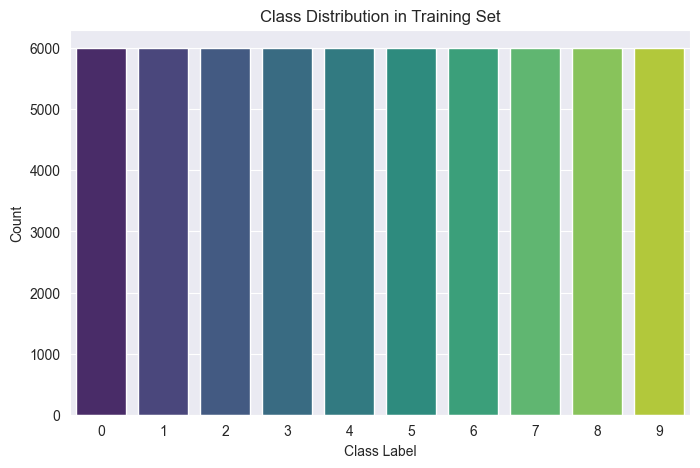

Class counts:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Is dataset imbalanced? No


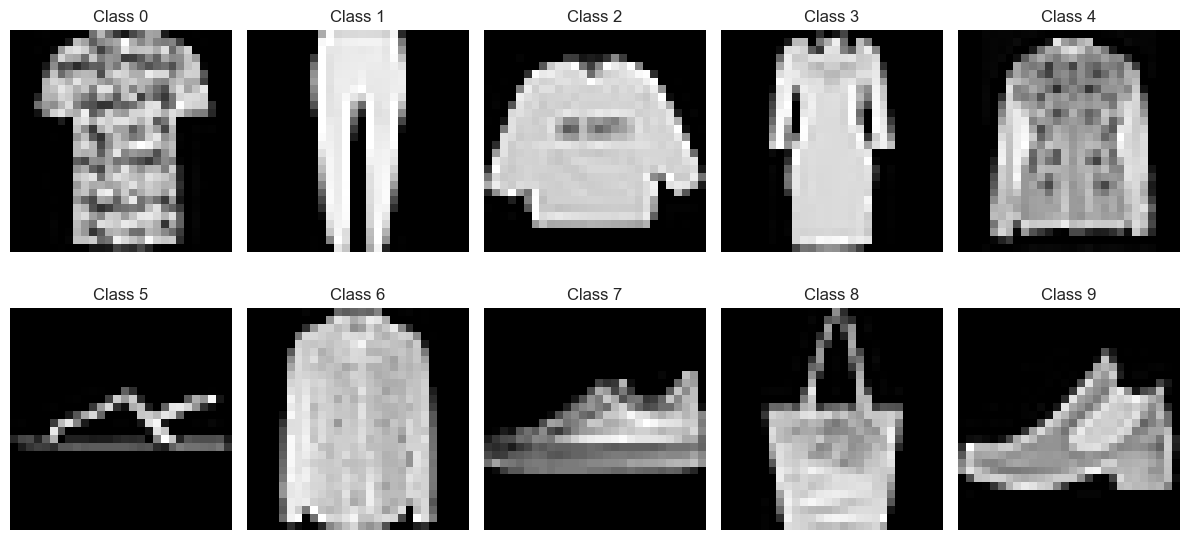

Computing mean/std: 100%|██████████| 60000/60000 [00:03<00:00, 15783.56it/s]


Dataset mean: 0.286105215549469
Dataset std: 0.35281121730804443
Preprocessing pipeline created successfully.
Train samples: 42000
Validation samples: 9000
Test samples: 9000
Dataloaders created.


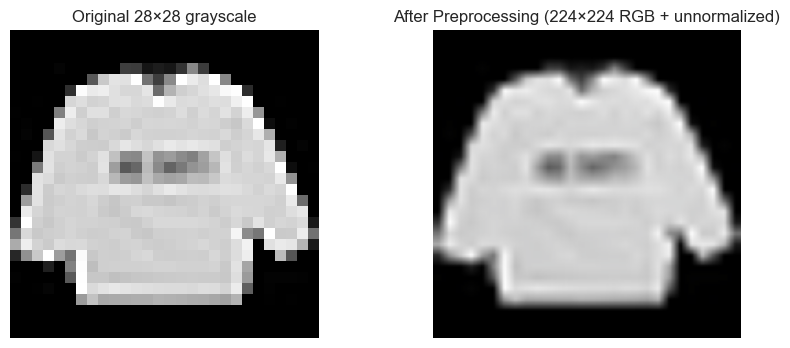

In [3]:
%run ./01_eda_preprocessing.ipynb

In [4]:
# TODO: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import os
from tqdm import tqdm

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.6.0+cu124
True
NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
# TODO: Load DataLoaders from notebook 01
# Assuming you saved DataLoaders or can import them
# Example: from data_exploration_preprocessing import train_loader, val_loader, test_loader
# If not, recreate datasets and loaders with the same preprocessing pipeline


num_classes = 10  # Fashion-MNIST has 10 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [7]:
# TODO: Load pretrained model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18 = resnet18.to(device)
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# TODO: Implement transfer learning strategy

# Strategy:
# Freeze all convolutional layers (feature extractor)
for param in resnet18.parameters():
    param.requires_grad = False

# Replace final fully connected layer
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18.fc.requires_grad = True  # only this layer is trainable

# Move model to device
resnet18 = resnet18.to(device)

print("Transfer learning strategy applied: frozen conv layers, fine-tune FC layer")


Transfer learning strategy applied: frozen conv layers, fine-tune FC layer


In [9]:
# TODO: Set up baseline hyperparameters
learning_rate = 1e-3
batch_size = 64
num_epochs = 10  # choose a value in 5-15 as recommended
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=learning_rate)

print(f"Hyperparameters: lr={learning_rate}, batch_size={batch_size}, epochs={num_epochs}")


Hyperparameters: lr=0.001, batch_size=64, epochs=10


In [10]:
# TODO: Initialize TensorBoard logger
log_dir = "runs/baseline_resnet18"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Log hyperparameters
writer.add_text("Hyperparameters", f"lr={learning_rate}, batch_size={batch_size}, epochs={num_epochs}")


In [11]:
# TODO: Implement training loop

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [12]:
# TODO: Implement validation loop

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [13]:
# TODO: Train baseline model

train_losses, val_losses = [], []
train_accs, val_accs = [], []

save_dir = "./saved_models/baseline_pretrained"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(resnet18, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(resnet18, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Log to TensorBoard
    writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    writer.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)

    # Save checkpoint
    checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}.pt")
    torch.save(resnet18.state_dict(), checkpoint_path)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  9.18it/s]


Train Loss: 0.6565, Train Acc: 0.7895
Val Loss: 0.4652, Val Acc: 0.8386
Epoch 2/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  9.10it/s]


Train Loss: 0.4494, Train Acc: 0.8435
Val Loss: 0.4296, Val Acc: 0.8476
Epoch 3/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  8.90it/s]


Train Loss: 0.4203, Train Acc: 0.8519
Val Loss: 0.4040, Val Acc: 0.8566
Epoch 4/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  9.04it/s]


Train Loss: 0.3984, Train Acc: 0.8583
Val Loss: 0.3998, Val Acc: 0.8536
Epoch 5/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  9.18it/s]


Train Loss: 0.3898, Train Acc: 0.8622
Val Loss: 0.3917, Val Acc: 0.8568
Epoch 6/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  8.99it/s]


Train Loss: 0.3828, Train Acc: 0.8636
Val Loss: 0.3848, Val Acc: 0.8618
Epoch 7/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  9.18it/s]


Train Loss: 0.3772, Train Acc: 0.8647
Val Loss: 0.3775, Val Acc: 0.8639
Epoch 8/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  9.24it/s]


Train Loss: 0.3712, Train Acc: 0.8680
Val Loss: 0.4056, Val Acc: 0.8517
Epoch 9/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  9.18it/s]


Train Loss: 0.3663, Train Acc: 0.8688
Val Loss: 0.3869, Val Acc: 0.8606
Epoch 10/10


Validation: 100%|██████████| 141/141 [00:15<00:00,  8.96it/s]


Train Loss: 0.3645, Train Acc: 0.8708
Val Loss: 0.3757, Val Acc: 0.8643


In [14]:
# TODO: Evaluate baseline on test set
resnet18.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)


Testing: 100%|██████████| 141/141 [00:15<00:00,  8.94it/s]

Test Accuracy: 0.8546
Precision: 0.8555, Recall: 0.8546, F1-score: 0.8534
Confusion Matrix:
 [[699   0  25  75   3   2  86   0  10   0]
 [  0 866   6  23   1   0   3   0   1   0]
 [ 10   1 773   8  54   0  52   0   2   0]
 [ 24   7  19 794  23   1  31   0   1   0]
 [  4   1 133  58 625   0  76   0   3   0]
 [  0   0   0   1   0 852   1  30   5  11]
 [126   0 102  52  76   1 534   0   9   0]
 [  0   0   0   0   0  31   0 847   1  21]
 [  1   0   7   9   3   4   6   1 869   0]
 [  2   0   2   3   0  12   1  46   2 832]]


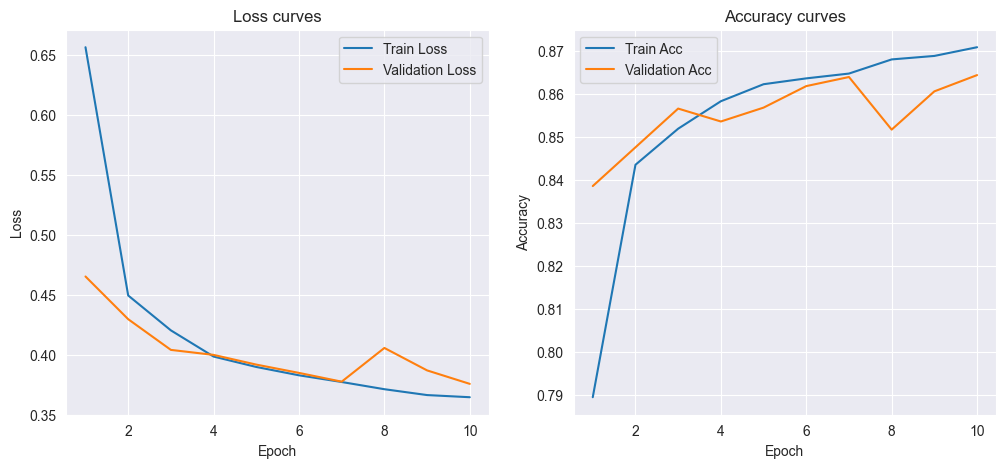

In [15]:
# TODO: Plot training curves
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy curves")

plt.show()


The fine-tuned ResNet-18 model achieved strong performance on Fashion-MNIST, with a test accuracy of 85.46% and balanced precision, recall, and F1-score. Training and validation curves show steady convergence, with only a minor fluctuation around epoch 8, which does not indicate systematic overfitting.

The confusion matrix reveals that the model performs well across most classes, but struggles with visually similar categories such as shirts, T-shirts/tops, and coats, which is expected for Fashion-MNIST. Since only the final layer was trained, the ImageNet feature extractor transferred effectively. Further gains could be achieved by unfreezing deeper layers or applying additional data augmentation.

In [17]:
# TODO: Save baseline model checkpoint
final_checkpoint = os.path.join(save_dir, "model_checkpoint.pt")
torch.save(resnet18.state_dict(), final_checkpoint)
print(f"Baseline ResNet18 checkpoint saved to {final_checkpoint}")


Baseline ResNet18 checkpoint saved to saved_models/baseline_pretrained\model_checkpoint.pt
